In [12]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("RajatSachdeva5y_6m.pdf")
resume = loader.load()
resume="\n".join(doc.page_content for doc in resume)

In [13]:
# from docx2pdf import convert

# convert("Draft_AI_LLM_Engineer.docx")
# convert("input.docx", "output.pdf")
# convert("my_docx_folder/")

In [15]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("JD/Draft_AI_LLM_Engineer.pdf")
jd = loader.load()
jd="\n".join(doc.page_content for doc in jd)

# **Agentic RAG Implementation**

# Defining Custom Tools

### Tool for downloading the interview chat history

In [2]:
from langchain.tools import tool
import os

@tool
def store_history(interview_doc:str, candidate:str) -> str:
    """
    Download the chat history on the system
    """

    # function definition starts from here

    directories=os.listdir()
    if 'interview' not in directories:
        os.mkdir('interview')

    file_path=f"interview/{candidate}.txt"

    with open(file_path,'w+') as file:
        file.writelines(interview_doc)

    return file_path


print("tool name:",store_history.name)
print("tool description:",store_history.description)
print("tool arguments:",store_history.args)

tool name: store_history
tool description: Download the chat history on the system
tool arguments: {'interview_doc': {'title': 'Interview Doc', 'type': 'string'}, 'candidate': {'title': 'Candidate', 'type': 'string'}}


##### Test run

In [7]:
store_history(tool_input={'interview_doc':'test','candidate':'test'})

c:\Users\BYPB5362\AppData\Local\Programs\Python\Python312\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


'interview/test.txt'

### Tool for testing against the benchmark

In [3]:
from langchain.tools import tool
from dotenv import load_dotenv
from openai import AzureOpenAI
import pandas as pd
import os

load_dotenv()


@tool
def get_report(questions:list, responses:list) -> str:
    """
    Test the interview chat against a benchmark and store the report 
    """

    rubrics=pd.read_csv("eval_rubrics.csv")

    # function definition starts here

    client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""You are a corporate interviewer responsible for grading the candidates according to their responses \
             This is the criterian for evaluation {rubrics}. \

             Question asked from the candidate: {questions[-1]}. \
             Response given by the candidate: {responses[-1]}. \
             Just give the scores without explaination under each criteria according to the relevance to the job. \
             Give answer in the following format: Relevance,4\nAccuracy,3\nClarity,3\nDepth,2\nLanguage Use,3\nCompleteness,2 
 """}])

    score=response.choices[0].message.content
    # score=score.replace(',',':')

    return score

            #  This is the candidate's resume: {resume}. \
            #  This is the job description: {jd}. \

print("tool name:",get_report.name)
print("tool description:",get_report.description)
print("tool arguments:",get_report.args)

tool name: get_report
tool description: Test the interview chat against a benchmark and store the report
tool arguments: {'questions': {'title': 'Questions', 'type': 'array', 'items': {}}, 'responses': {'title': 'Responses', 'type': 'array', 'items': {}}}


In [12]:
from io import StringIO

score=get_report(tool_input={
    'questions':["""Sure, Rajat. Let's shift to another aspect of your experience mentioned in your resume.

You have substantial experience with Computer Vision and specifically mentioned using YOLO for object detection.

**Question: Can you explain the process of setting up and using a YOLO (You Only Look Once) model for object detection? How do you prepare your dataset, train the model, and evaluate its performance? What considerations do you keep in mind for optimizing the training process?**"""],
    'responses':["""can we end this now
"""]})
score_csv = StringIO(score)
score=score.replace(',',':')
score

'Relevance:1\nAccuracy:1\nClarity:1\nDepth:1\nLanguage Use:2\nCompleteness:1'

In [13]:
df=pd.read_csv(score_csv,header=None)
result_dict = df.set_index(0).to_dict()[1]
result_dict

{'Relevance': 1,
 'Accuracy': 1,
 'Clarity': 1,
 'Depth': 1,
 'Language Use': 2,
 'Completeness': 1}

### Question generating LLM as Tool

In [4]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI
from langchain.tools import tool

load_dotenv()

@tool
def ask_question(resume:str, jd:str, chat_history:str) -> str:
    """
    LLM for generating a new question to be asked from the candidate
    """

    # function definition starts here

    client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""You are a corporate interviewer responsible for taking candidate interviews. \
             This is a technical round, hence you need to ask questions regarding relevant technologies. \
             You may ask some short syntax or a conceptual question. \
             This is the job description: {jd}. \
             This is the candidate's resume: {resume}. \
             This is the past interaction you had with the candidate: {chat_history}. \
             Either ask a review question on candidate's last reponse or ask a new question. \
             Make sure to only ask a single question. \
             The question needs to be relevant to the job description or the candidate's past experience."""}])

    question=response.choices[0].message.content

    return question


print("tool name:",ask_question.name)
print("tool description:",ask_question.description)
print("tool arguments:",ask_question.args)

tool name: ask_question
tool description: LLM for generating a new question to be asked from the candidate
tool arguments: {'resume': {'title': 'Resume', 'type': 'string'}, 'jd': {'title': 'Jd', 'type': 'string'}, 'chat_history': {'title': 'Chat History', 'type': 'string'}}


In [3]:
from langchain.tools.render import render_text_description

rendered_tools = render_text_description([ask_question,store_history])
rendered_tools

'ask_question(resume: str, jd: str, chat_history: str) -> str - LLM for generating a new question to be asked from the candidate\nstore_history(interview_doc: str, candidate: str) -> str - Download the chat history on the system'

# ***Agent Implementation without langgraph***

In [11]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

load_dotenv()

client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

questions=[]
responses=[]
scores={}

def handle_interview(jd, resume, initial_chat_history):
    chat_history = initial_chat_history
    while True:
        decision = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""
                You are a corporate interviewer responsible for taking candidate interviews. Decide whether to ask another question or end the conversation.
                This is the job description: {jd}.
                This is the candidate's resume: {resume}.
                This is the past interaction you had with the candidate: {chat_history}.
                Respond with 'ask' to ask another question or 'end' to end the conversation.
                """}]).choices[0].message.content
        if decision == 'ask':
            question = ask_question(tool_input={'resume':resume, 'jd':jd, 'chat_history':chat_history})
            questions.append(question)
            chat_history += f"\nInterviewer: {question}"
            print(f"Interviewer: {question} \n")
            # break ################################################# for testing
            candidate_response = input("Candidate: ")
            responses.append(candidate_response)

            score=get_report(tool_input={'questions':questions,'responses':responses})

            chat_history += f"\nCandidate: {candidate_response}\n"
            chat_history += f"\nScore: {score.replace(',',':')}\n\n\n"

            from io import StringIO
            score_csv = StringIO(score)
            temp_df=pd.read_csv(score_csv,header=None)
            result_dict = temp_df.set_index(0).to_dict()[1]
            for i in list(result_dict.keys()):
                if i not in scores:
                    scores[i]=[result_dict[i]]
                else:
                    scores[i].append(result_dict[i])

        elif decision == 'end':
            print("Interview ended.")
            break
        else:
            print("Unexpected decision. Ending interview.")
            break

    store_history(tool_input={'interview_doc':chat_history,'candidate':'test'})
    scores.to_csv("reports/test.csv",index=False)

handle_interview(jd=jd, resume=resume, initial_chat_history="")

Interviewer: Thank you for detailing your extensive experience, Rajat. You've touched on a significant number of points related to AI, ML, and automation frameworks. Given that the job role includes responsibilities like designing novel LLM architectures and advanced machine learning models training using frameworks such as TensorFlow and PyTorch, could you please elaborate on any specific projects where you've designed or implemented custom LLM architectures or applied advanced deep learning techniques using TensorFlow or PyTorch? Can you provide details on the challenges you faced and how you addressed them?


# ***Agent Implementation using langgraph***

In [2]:
from typing import TypedDict

class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: str
    decision: str
    question: str
    answer: str

In [6]:
from langchain.tools import tool
import os

@tool
def store_history(state: AgentState) -> AgentState:
    """
    Download the chat history on the system
    """

    # function definition starts from here

    directories=os.listdir()
    if 'interview' not in directories:
        os.mkdir('interview')

    file_path=f"interview/test.txt"

    with open(file_path,'w+') as file:
        file.writelines(chat_history)

    return {"message":"chat history stored successfully"}


from langchain.tools import tool
from dotenv import load_dotenv
from openai import AzureOpenAI
import pandas as pd
import os

load_dotenv()


@tool
def get_report(state: AgentState) -> AgentState:
    """
    Test the interview chat against a benchmark and store the report 
    """

    rubrics=pd.read_csv("eval_rubrics.csv")

    # function definition starts here

    client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""You are a corporate interviewer responsible for grading the candidates according to their responses \
             This is the criterian for evaluation {rubrics}. \

             Question asked from the candidate: {state['question'][-1]}. \
             Response given by the candidate: {state['answer'][-1]}. \
             Just give the scores without explaination under each criteria according to the relevance to the job. \
             Give answer in the following format: Relevance,4\nAccuracy,3\nClarity,3\nDepth,2\nLanguage Use,3\nCompleteness,2 
 """}])

    score=response.choices[0].message.content
    # score=score.replace(',',':')

    return score

            #  This is the candidate's resume: {resume}. \
            #  This is the job description: {jd}. \

import os
from dotenv import load_dotenv
from openai import AzureOpenAI
from langchain.tools import tool

load_dotenv()

@tool
def ask_question(state: AgentState) -> AgentState:
    """
    LLM for generating a new question to be asked from the candidate
    """
    print("generate question")
    # function definition starts here

    client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""You are a corporate interviewer responsible for taking candidate interviews. \
             This is a technical round, hence you need to ask questions regarding relevant technologies. \
             You may ask some short syntax or a conceptual question. \
             This is the job description: {jd}. \
             This is the candidate's resume: {resume}. \
             This is the past interaction you had with the candidate: {chat_history}. \
             Either ask a review question on candidate's last reponse or ask a new question. \
             Make sure to only ask a single question. \
             The question needs to be relevant to the job description or the candidate's past experience."""}])

    question=response.choices[0].message.content
    return {"question":question}


# Defining the boss (supervising LLM)

In [7]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI
from langchain.tools.render import render_text_description
from langchain_core.output_parsers import JsonOutputParser

load_dotenv()

chat_history=""


tools=[ask_question,store_history]

rendered_tools = render_text_description(tools)

def handle_interview(state: AgentState) -> AgentState:
    print("what next?")
    client = AzureOpenAI(
    api_key = os.getenv("AZURE_OPENAI_4o_API_KEY"),  
    api_version = os.getenv("API_VERSION_4o"),
    azure_endpoint = os.getenv("AZURE_OPENAI_4o_ENDPOINT")
    )

    decision = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": f"""
                You are a corporate interviewer responsible for taking candidate interviews. Decide whether to ask another question or end the conversation.
                This is the job description: {jd}.
                This is the candidate's resume: {resume}.
                This is the past interaction you had with the candidate: {chat_history}.
                Respond with 'ask' to ask another question or 'end' to end the conversation.
                """}]).choices[0].message.content

    state["decision"]=decision    
    return state


In [8]:
def human_interaction(state: AgentState) -> AgentState:
    # This function should prompt for human input and update the state accordingly
    human_decision = input("RESPONSE: ")
    state['answer'].append(human_decision)
    return {"answer":human_decision}

# Langgraph starts

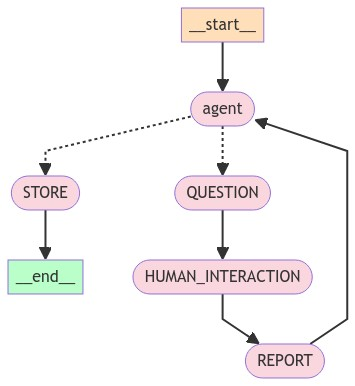

In [10]:
from langgraph.graph import END, StateGraph, START, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint import MemorySaver
from typing import Annotated, Literal, TypedDict,Sequence
from langgraph.graph.message import add_messages


# class AgentState(TypedDict):
#     # The add_messages function defines how an update should be processed
#     # Default is to replace. add_messages says "append"
#     messages: str
#     decision: str
#     question: str
#     answer: str

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", handle_interview)  # agent
QUESTION = ToolNode([ask_question])
workflow.add_node("QUESTION", ask_question) 
REPORT = ToolNode([get_report])
workflow.add_node("REPORT", REPORT)
STORE = ToolNode([store_history])
workflow.add_node("STORE", STORE) 

workflow.add_node("HUMAN_INTERACTION", human_interaction)

workflow.add_edge(START, "agent")

def decision_function(state: AgentState) -> Literal["QUESTION", "STORE"]:
    if state["decision"] == "ask":
        return "QUESTION"
    else:
        return "STORE"


workflow.add_conditional_edges("agent", decision_function,)

workflow.add_edge("QUESTION", "HUMAN_INTERACTION")
workflow.add_edge("HUMAN_INTERACTION","REPORT")
workflow.add_edge("REPORT","agent")
workflow.add_edge("STORE", END)

checkpointer = MemorySaver()
# Compile
graph = workflow.compile(checkpointer=checkpointer)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [16]:
from pprint import pprint

inputs={"messages":"start interview","decision":"","question":"","answer":""}
                            
# Iterate over the stream of outputs from the graph
for output in graph.stream(inputs,config={"configurable": {"thread_id": 42}}):
    for key, value in output.items():
        # Print the node key
        pprint(f"Node '{key}':")

        # Print the value associated with the node (state information)
        pprint(value, indent=2, width=80, depth=None)  # Optionally, print full state
    pprint("\n---\n")  # Separate nodes with a line


what next?
"Node 'agent':"
{'answer': '', 'decision': 'ask', 'messages': 'start interview', 'question': ''}
'\n---\n'


ValidationError: 1 validation error for ask_questionSchema
state
  field required (type=value_error.missing)